In [1]:
import glob
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Input, BatchNormalization, Dropout
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.preprocessing import image_dataset_from_directory
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from cv2 import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext tensorboard
%matplotlib inline

In [2]:
img_size = (112,112)
batch_size = 32
base_learning_rate = 1e-6

In [3]:
trainData = image_dataset_from_directory(
    './dataset/train/',
    color_mode='rgb',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=img_size,
    seed=1337
)

validData = image_dataset_from_directory(
    './dataset/val/',
    color_mode='rgb',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=img_size,
    seed=1337
)

testData = image_dataset_from_directory(
    './dataset/test/',
    color_mode='rgb',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=img_size,
    seed=1337
)

Found 40200 files belonging to 8 classes.
Found 3450 files belonging to 8 classes.
Found 2220 files belonging to 8 classes.


In [4]:
class_names = list(trainData.class_names)
num_classes = len(class_names)

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

trainData = trainData.prefetch(buffer_size=AUTOTUNE)
validData = validData.prefetch(buffer_size=AUTOTUNE)
testData = testData.prefetch(buffer_size=AUTOTUNE)

In [6]:
def build_model():
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size + (3,)))
    
    
    inputs = Input(name='input_layer', shape=(img_size + (3,)))
    x = preprocess_input(inputs)
    x = resnet50(x)
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [7]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 112, 112, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 112, 112, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 112, 112, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448 

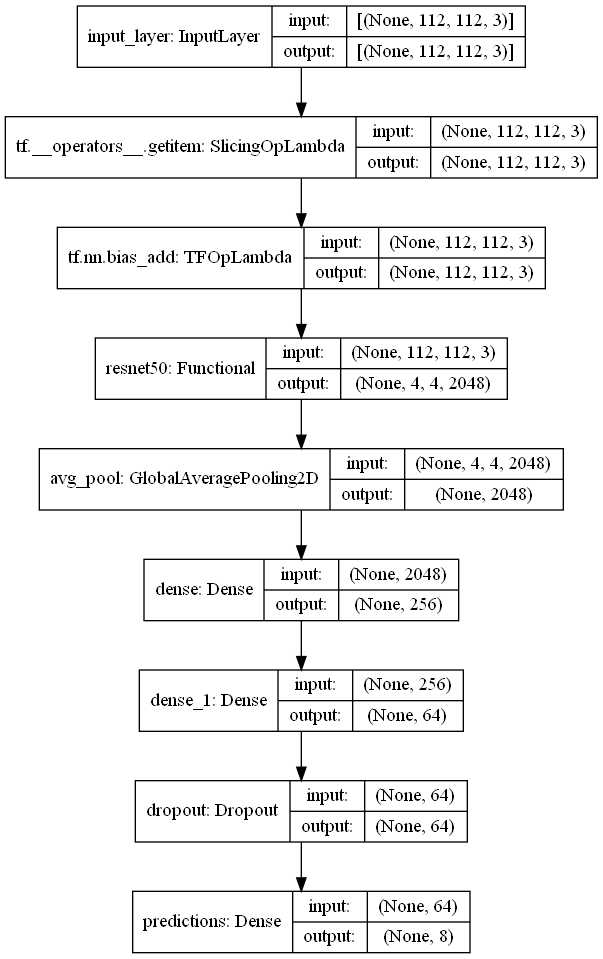

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
model.compile(
  optimizer= Adam(learning_rate=base_learning_rate),
  loss='categorical_crossentropy',
  metrics= [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.CategoricalAccuracy()]
  )

In [13]:
log_dir = "./log/tensorboard/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(
    log_dir= log_dir, 
    histogram_freq=1,
    write_grads=False
    )

earlystopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=1e-7,
    patience=30,
    restore_best_weights=True,
    verbose=1
    )

modelcheckpoints = ModelCheckpoint(
    './log/checkpoints/{val_loss:.4f}-{val_accuracy:.4f}.h5',
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
    )

csvlogger = CSVLogger(
    './log/log.csv'
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    min_lr=0.5e-6,
    verbose=1
    )

In [15]:
history = model.fit(
    trainData,
    epochs=1,
    validation_data=validData
    )

1257/1257 [==============================] - 933s 738ms/step - loss: 0.0235 - precision: 0.9965 - recall: 0.9959 - categorical_accuracy: 0.9962 - val_loss: 0.3557 - val_precision: 0.9498 - val_recall: 0.9435 - val_categorical_accuracy: 0.9449


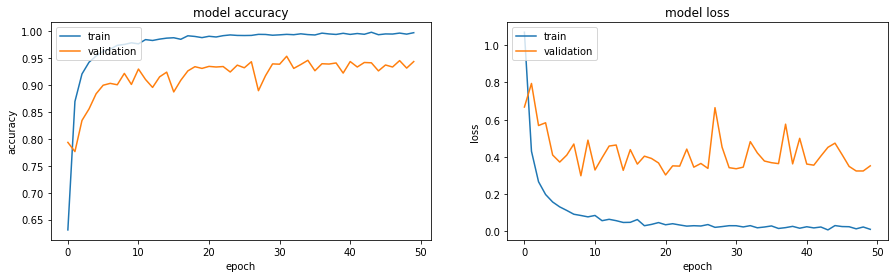

<Figure size 432x288 with 0 Axes>

In [15]:
plt.figure(figsize=(15, 4))
plt.subplot(121),
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig("cnn_plot.png")

In [16]:
model.save('./log/50epoch.h5')

In [6]:
model = load_model('./log/50epoch.h5')

In [ ]:
%tensorboard --logdir log2/tensorboard --host localhost --port 8888

In [17]:
test_loss, test_prec, test_rec, test_accuracy = model.evaluate(testData)

70/70 [==============================] - 49s 600ms/step - loss: 4.5830 - precision: 0.4817 - recall: 0.4626 - categorical_accuracy: 0.4698
